In [1]:
import re
import pandas as pd

### 1. Lexicon-based Libraries

In [2]:
fire_list = ["cigar", "combustible", "welding", "gasoline", "lighter", "malfunction", 
             "wiring", "circuit", "electric", "arson", "act of god", "human error"]

negation_words = ["no", "non", "not", "isn't", "aren't", "wasn't", "weren't", "haven't", "hasn't", "hadn't", 
                  "don't", "doesn't", "didn't", "can't", "cannot", "couldn't", "mightn't", "mayn't",
                  "mustn't", "impossible", "shan't", "shouldn't", "won't", "wouldn't", "doubt", "doubted",
                  "needn't", "oughtn't", "unlikely", "nothing", "shocked", "imaginary", "dismiss", "ironic", 
                  "deny", "denies", "denied", "without", "absence", "declined", "negative", "nobody", "cautious", 
                  "strange", "suspicious", "coverup", "rejected", "dismissed", "disagree", "exclude", "excluded",  
                  "ashamed", "conspiracy", "reject", "fake", "rumor", "upgraded", "replaced", "revised", "quickest",
                  "restored", "updated", "overhauled", "surprised", "incorrect", "incorrectly", "dispute", "disputed",
                  "pretending"]

negation_phrases = ["rule out", "rules out", "ruled out", "ruling out", "hard to believe", "political decision", 
                    "rushed to say", "too soon", "quick to say", "smells fishy", "in spite", "so quick", 
                    "ass kicked", "to blame", "be ashamed", "awfully strange"]

comment_negation_words = ["but", "however", "nevertheless", "ironic", "cautious", "deny", "denies", "denied", 
                          "strange", "suspicious", "coverup", "nobody", "disagree", "impossible", "though",
                          "stupid", "stupidity", "lie", "lied", "lying", "ridiculous", "fake", "doubt", "doubted",
                          "while", "gullible", "hiding", "hide", "unacceptable", "bullshit", "misleading"]

comment_negation_phrases = ["🙄", "hard to believe", "political decision","i would really", "difficult to accept",
                            "rushed to say", "too quick", "too soon", "quick to say", "smells fishy", 
                            "as long as", "believe different", "even while", "brain worms", "we're not gonna",
                            "all fail", "so quick", "calling bs", "need answers", "never be known",
                            "to blame", "too effective to", "doesn't work", "does not work", 
                            "short circuit in thinking","awfully strange", "don't believe", 
                            "doesn't burn", "can't trust", "gullible idiot"]

tag_question_negation = ["don't they", "didn't they", "don't we", "didn't we", "won't they", "won't we", "don't you",
                         "shouldn't they", "shouldn't we", "aren't we", "aren't they", "isn't it", "wasn't it"]

uncertain_words = ["don't know", "idk", "hope", "pray", "wish", "hoping", "investigate whether",
                   "looking into whether"]

In [3]:
assert len(negation_words) == len(set(negation_words)), ("duplicates in the negation words")
assert len(negation_phrases) == len(set(negation_phrases)), ("duplicates in the negation phrases")
assert len(comment_negation_words) == len(set(comment_negation_words)), ("duplicates in the comment words")
assert len(comment_negation_phrases) == len(set(comment_negation_phrases)), ("duplicates in the comment phrases")
assert len(tag_question_negation) == len(set(tag_question_negation)), ("duplicates in the tag question")
assert len(uncertain_words) == len(set(uncertain_words)), ("duplicates in the uncertain words")

### 2. Text Cleaning and Model Design

In [4]:
def remove_stopwords(tweet):
    """
    Aim to remove stopwords. 
    """
    tweet_words = tweet.split()
    tweet_words = [word for word in tweet_words if word not in stopwords]
    tweet = ' '.join(tweet_words)
    return tweet

def remove_text(tweet):
    """
    Remove RT: @user, http://, and @user in a tweet.
    """
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub('(RT\s@[A-Za-z0-9-_]+[A-Za-z0-9-_]: +)', '', tweet)
    tweet = re.sub('(@[A-Za-z0-9-_]+[A-Za-z0-9-_]+)', '', tweet)
    return tweet

def clean_text(tweet):
    """
    Clean a tweet and return a list of texts.
    """
    tweet = remove_text(tweet)
    tweet = tweet.lower().strip()
    tweet = tweet.replace("&#39;", "'")
    tweet = tweet.replace("&quot;", "")
    tweet = tweet.replace(" &amp;", "")
    tweet = tweet.replace("&amp", "")
    # we consider circuit and wiring all as electric factors
    tweet = tweet.replace("circuit", 'electric') 
    tweet = tweet.replace("wiring", 'electric')
    tweet = tweet.replace("but also", "also")
    tweet = tweet.replace("starter,", "starter")
    tweet = tweet.replace("rod,", "rod")
    tweet = tweet.replace("blowtorch,", "blowtorch")
    tweet = tweet.replace("arson,", "arson")
    tweet = tweet.replace("electric welding", "welding")
    tweet = tweet.replace(", and", " and")
    tweet = tweet.replace(" but ", ", but ")
    tweet = tweet.replace(" even though ", ", even though ")
    tweet = tweet.replace("\n", ". ")
    tweet = tweet.replace("\r", ". ")
    tweet = tweet.replace("\r\n", ". ")
    tweet = tweet.replace("----", ".")
    tweet = tweet.replace("...", ".")
    tweet = tweet.replace("…", ".")
    tweet = tweet.replace("’", "'")
    tweet = tweet.replace(",", ",.")
    tweet = tweet.replace(";", ";.")
    tweet = tweet.replace("!", "!.")
    tweet = tweet.replace("?", "?.")
    return tweet

def remove_punctuations(text):
    """
    Remove punctuations except '?' and "'" in the text.
    """
    punctuations = '''!()-[]{};:"\,<>./@#$%^&*_~'''
    no_punc_text = ""
    for char in text:
        if char not in punctuations:
            no_punc_text += char
    return no_punc_text

In [5]:
def check_fireword(text):
    """
    Check the keyword of fire causes in a text.
    """
    word_list = [word for word in fire_list if word in text.lower()]
    return word_list


def check_negation(text):
    """
    Check the negation words and phrases in a text.
    """
    neg_count = 0
    for phrase in tag_question_negation:
        text = text.lower().replace(phrase, "").strip()
    for word in negation_words:
        if word in text.lower().split():
            neg_count += 1
    for phrase in negation_phrases:
        if phrase in text:
            neg_count += 1
    #print("negation", neg_count)
    return -1 if (neg_count % 2) == 1 else 1


def check_comment_multiple(fireword, text, next1_text, next2_text):
    """
    Check the adversative relation for a text with multiple fire causes keywords.
    """
    neg_count = 0
    negation_list = negation_words + negation_phrases
    negation = ' '.join(negation_list)
    next_text = next1_text + " " + next2_text
    #print(next_text)
    for word in comment_negation_words:
        if word in text.split() and word not in negation and text.index(word) > text.index(fireword):
            neg_count += 1
        elif word in next_text.split():
            neg_count += 1
    for phrase in comment_negation_phrases:
        if phrase in text and phrase not in negation and text.index(phrase) > text.index(fireword):
            neg_count += 1
        elif phrase in next_text:
            neg_count += 1
    #print("comment", neg_count)
    return -1 if neg_count > 0 else 1


def check_comment_one(fireword, text, subseq_text):
    """
    Check the adversative relation for a text with only one fire cause keyword.
    """
    neg_count = 0
    negation_list = negation_words + negation_phrases
    negation = ' '.join(negation_list)
    for word in comment_negation_words:
        if word in text.split() and word not in negation and text.index(word) > text.index(fireword):
            neg_count += 1
        elif word in subseq_text.lower().split():
            neg_count += 1
    for phrase in comment_negation_phrases:
        if phrase in text and phrase not in negation and text.index(phrase) > text.index(fireword):
            neg_count += 1
        elif phrase in subseq_text:
            neg_count += 1
    #print("comment", neg_count)
    return -1 if neg_count > 0 else 1


def check_uncertain(fireword, text, last_text):
    """
    Check the uncertainty of a text.
    """
    if text == last_text and last_text.strip()[-1] == "?" and fireword in last_text:
        return 0
    elif fireword in text and any(word in text for word in uncertain_words):
        return 0
    else:
        return 1

In [6]:
def label_tweet(tweet):
    """
    Label a tweet with fire causes keywords.
    """
    tweet = clean_text(tweet)
    fireword_list = check_fireword(tweet)
    #print(fireword_list)
    
    text_list = tweet.split('. ')
    text_list = filter(None, text_list)
    text_list = [remove_punctuations(text) for text in text_list]
    text_list = [text.rstrip() for text in text_list]
    #print(text_list)
    
    last_text = text_list[-1]
    text_list += ["-"] + ["-"] 
    
    fire_causes = list()
    if len(fireword_list) == 1:
        fireword = fireword_list[0]
        for i in range(len(text_list)):
            text = text_list[i]
            subseq_text = ' '.join(text_list[i+1:])
            if fireword in text:
                negation = check_negation(text)
                #print("negation", negation)
                comment = check_comment_one(fireword, text, subseq_text)
                #print("comment", comment)
                uncertainty = check_uncertain(fireword, text, last_text)
                #print("uncertainty", uncertainty)
                polarity = negation * comment * uncertainty
                fire_causes.append((fireword, polarity))
                          
    elif len(fireword_list) > 1:               
        for fireword in fireword_list:
            for i in range(len(text_list)-2):
                text = text_list[i]
                next1_text = text_list[i+1]
                next2_text = text_list[i+2]
                if fireword in text:
                    negation = check_negation(text)
                    #print("negation", negation)
                    comment = check_comment_multiple(fireword, text, next1_text, next2_text)
                    #print("comment", comment)
                    uncertainty = check_uncertain(fireword, text, last_text)
                    #print("uncertainty", uncertainty)
                    polarity = negation * comment * uncertainty
                    fire_causes.append((fireword, polarity))
    
    fire_causes_dict = {}
    for (key, value) in fire_causes:
        fire_causes_dict[key] = value
    
    return fire_causes_dict

In [7]:
# This is a test
tweet1 = "The police ruled out the factor of arson"

label_tweet(tweet1)

{'arson': -1}

### 4. Read Sample Data
Restrictions apply to the availability of Twitter data, which are used under license for the current study, and so specific tweets messages are not publicly available. We forgot to save the tweet IDs when downloading the data for this research. Therefore, if you need our manual classifications for those tweets, please directly contact us. Data files are available upon reasonable requests.

In [8]:
from sklearn.metrics import confusion_matrix
df_sample = pd.read_excel('sample_verification.xlsx')

[[128   4  59]
 [  1   7   9]
 [ 25   7 325]]


<ipython-input-9-ade454efe700>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-9-ade454efe700>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


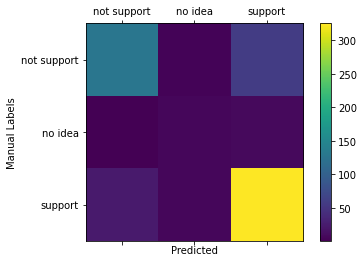

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

labels = ["not support", "no idea", "support"]
matrix = confusion_matrix(df_sample['manually_label'], df_sample['machined_label'])
print(matrix)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Manual Labels')
plt.show()

In [10]:
from sklearn.metrics import classification_report

print(classification_report(df_sample['manually_label'], df_sample['machined_label']))

              precision    recall  f1-score   support

          -1       0.83      0.67      0.74       191
           0       0.39      0.41      0.40        17
           1       0.83      0.91      0.87       357

    accuracy                           0.81       565
   macro avg       0.68      0.66      0.67       565
weighted avg       0.82      0.81      0.81       565

